## AI prompts I used during this exercise
1. "You are an experienced healthcare data analyst. I am new to healthcare data and am working with a cardiac health dataset. For the following data field names, tell me what these names commonly refer to in healthcare data"
2. "In what situations would diastolic blood pressure be very relevant to a heart complication while systolic blood pressure is irrelevant?"

In [317]:
import pandas as pd
from tableone import TableOne
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# DATA CLEANING

In [318]:
path = '/Users/connorkenehan/Downloads/data.csv'
df = pd.read_csv(path)
df.head()

,subject_id,is_eligible,days_since_enrollment,cohort,brthdat_coded,age,sex,sex_coded,dmcbpot_coded,ethnicity,...,max_ventricular_rate_bpm,mean_temperature_c,sd_temperature_c,mean_heart_rate_variability_ms,sd_heart_rate_variability_ms,mean_systolic_bp,mean_diastolic_bp,mean_weight_kg,kccq_summary_score,ejection_fraction
0,101-0001,True,-1.0,Cohort 1,NaN,37.0,Female,2.0,1.0,Not Hispanic or Latino,...,NaN,NaN,NaN,NaN,NaN,109.217357,78.235861,71.90679,NaN,65.661492
1,101-0001,True,0.0,Cohort 1,NaN,37.0,Female,2.0,1.0,Not Hispanic or Latino,...,180.904516,34.256214,0.960859,55.151446,26.819374,124.217357,79.235861,51.29979,98.967333,65.661492
2,101-0001,True,1.0,Cohort 1,NaN,37.0,Female,2.0,1.0,Not Hispanic or Latino,...,114.904516,34.225616,0.938786,43.523030,22.737491,102.217357,68.235861,52.40779,NaN,65.661492
3,101-0001,True,2.0,Cohort 1,NaN,37.0,Female,2.0,1.0,Not Hispanic or Latino,...,139.904516,33.955553,0.957026,48.449361,25.358106,111.217357,76.235861,50.16479,NaN,65.661492
4,101-0001,True,3.0,Cohort 1,NaN,37.0,Female,2.0,1.0,Not Hispanic or Latino,...,132.904516,33.559629,1.073398,47.899977,27.223438,107.217357,65.235861,50.15079,NaN,65.661492


In [319]:
# Step 1: If there are any fully null columns, we won't learn anything from them, so we should drop them
fully_null_cols = df.columns[df.isnull().all()]
df_cleaned = df.drop(columns=fully_null_cols)

# Step 2: If there are any single-value columns, we won't learn anything from them either, so we should drop them
coded_cols_to_drop = [col for col in df_cleaned.columns if df_cleaned[col].nunique() <= 1]
df_cleaned = df_cleaned.drop(columns=coded_cols_to_drop)

# Step 3: Null-handle: if there are any missing demographics, let alone numbers, it'll be hard to interpret results
df_cleaned = df_cleaned.dropna(subset=['sex', 'ethnicity', 'race'])

# Step 4: Limit dataset to 0-14-post-enrollment-days
# It looks like only some patients have data outside of 0-14 days of enrollment...let's look only at days 0-14
df_cleaned = df_cleaned[(df_cleaned['days_since_enrollment'] >= 0) & (df_cleaned['days_since_enrollment'] <= 14)]

# Step 5: Check that the coding is done consistently, and remove it if it isn't
coded_cols = [col for col in df_cleaned.columns if col.endswith('_coded')]
coded_cols.remove('dmcbpot_coded') #we know this won't work with dmcbpot_coded
for col in coded_cols:
    # infer the name of the corresponding un-coded column (column name minus coded)
    non_coded_col = col[:-6]
    
    # get unique values from each column
    unique_col1 = df[col].dropna().unique()
    unique_col2 = df[non_coded_col].dropna().unique()

    # create a cartesian product using multiindex
    combinations = pd.MultiIndex.from_product([unique_col1, unique_col2], names=[col, non_coded_col]).to_frame(index=False)

    print(combinations) #this shows us that coding isn't done consistently, so we'll drop it and use the underlying fields

df_cleaned = df_cleaned.drop(columns=coded_cols)

# Step 6: if date and date_local are the same, we only need one of them, and date_local is less useful for timezone-agnostic comparison
df_cleaned = df_cleaned.drop(columns='date_local')

   sex_coded     sex
0        2.0  Female
1        2.0    Male
2        1.0  Female
3        1.0    Male
    race_coded                              race
0          5.0                             White
1          5.0  American Indian or Alaska Native
2          5.0         Black or African American
3          5.0                             Asian
4          1.0                             White
5          1.0  American Indian or Alaska Native
6          1.0         Black or African American
7          1.0                             Asian
8          3.0                             White
9          3.0  American Indian or Alaska Native
10         3.0         Black or African American
11         3.0                             Asian
12         2.0                             White
13         2.0  American Indian or Alaska Native
14         2.0         Black or African American
15         2.0                             Asian
   osnd_coded osnd
0         0.0   No
1         0.0  Yes
2    

In [320]:
# Step 7: Write out a cleaned dataset
df_cleaned.to_csv('analytic_dataset.csv', index=False)

# DESCRIPTIVE ANALYSIS

In [321]:
# Step 1: identify categorical vs continuous variables
categorical = ['is_eligible', 'cohort', 'age', 
               'sex', 'dmcbpot_coded', 'ethnicity', 
               'race', 'race_ethnicity', 'vstim', 
               'vsdat', 'date']
continuous = [field for field in df_cleaned.columns if field not in categorical and pd.api.types.is_numeric_dtype(df_cleaned[field])]

# Step 2: reformat ejection fraction data of interest
df_cleaned['is_of_interest'] = df_cleaned['ejection_fraction'] < 50
groupby = 'is_of_interest'

# Step 3: drop columns not of interest (ones we don't know much about or are redundant)
remove_columns = ['is_eligible', 'cohort', 'dmcbpot_coded',
          'ethnicity', 'race', 'vstim',
          'vsdat', 'date', 'subject_id', 
          'days_since_enrollment', 'subject_id', 'ejection_fraction','osnd']

def drop_fields(fields):
    return [field for field in fields if field not in remove_columns]

categorical = drop_fields(categorical)
continuous = drop_fields(continuous)
columns = categorical + continuous

mytable = TableOne(df_cleaned, 
                   columns=['sex','race_ethnicity','dmcbpot_coded','baseline_bmi','mean_weight_kg','max_active_hr','mean_sleep_hr','activity_hours','mean_temperature_c','sd_temperature_c', 'num_st_change_events','vssysbp','vsdiabp','vspulse','vsrr','oxsat','age'], 
                   categorical=['sex','race_ethnicity','dmcbpot_coded'], 
                   continuous=['baseline_bmi','mean_weight_kg','max_active_hr','mean_sleep_hr','activity_hours','mean_temperature_c','sd_temperature_c', 'num_st_change_events','vssysbp','vsdiabp','vspulse','vsrr','oxsat','age'], 
                   groupby='is_of_interest', pval=True)



In [322]:
mytable

Grouped by is_of_interest                                                   
                                                                                   Missing       Overall         False           True P-Value
n                                                                                                    900           795            105        
sex, n (%)                      Female                                                        495 (55.0)    465 (58.5)      30 (28.6)  <0.001
                                Male                                                          405 (45.0)    330 (41.5)      75 (71.4)        
race_ethnicity, n (%)           American Indian or Alaska Native                                15 (1.7)       0 (0.0)      15 (14.3)  <0.001
                                Asian                                                           30 (3.3)      30 (3.8)        0 (0.0)        
                                Black or African American                                     210 (23.3)    180 (22.6)      30 (28.6)        
                                Hispanic or Latino                                              60 (6.7)      60 (7.5)        0 (0.0)        
                                White                                                         585 (65.0)    525 (66.0)      60 (57.1)        
dmcbpot_coded, n (%)            0.0                                                           300 (33.3)    270 (34.0)      30 (28.6)  <0.001
                                1.0                                                           195 (21.7)    195 (24.5)        0 (0.0)        
                                None                                                          405 (45.0)    330 (41.5)      75 (71.4)        
baseline_bmi, mean (SD)                                                                  0    30.6 (7.6)    31.1 (7.8)     27.3 (4.9)  <0.001
mean_weight_kg, mean (SD)                                                              126   87.2 (23.7)   88.2 (23.8)    80.0 (21.8)   0.001
max_active_hr, mean (SD)                                                               115  165.4 (41.4)  166.1 (40.6)   159.5 (46.5)   0.200
mean_sleep_hr, mean (SD)                                                               204   66.3 (10.6)   65.8 (10.5)    69.7 (10.8)   0.003
activity_hours, mean (SD)                                                              115     2.4 (1.5)     2.4 (1.5)      2.4 (1.5)   0.780
mean_temperature_c, mean (SD)                                                          115    33.0 (1.4)    33.0 (1.4)     33.3 (1.0)   0.009
sd_temperature_c, mean (SD)                                                            115     1.1 (0.4)     1.1 (0.5)      1.0 (0.3)  <0.001
num_st_change_events, mean (SD)                                                        115  77.4 (108.0)  70.1 (102.4)  133.3 (132.4)  <0.001
vssysbp, mean (SD)                                                                       0  129.8 (21.3)  129.7 (21.3)   130.5 (21.7)   0.748
vsdiabp, mean (SD)                                                                       0   80.3 (11.9)   81.1 (10.8)    74.0 (16.8)  <0.001
vspulse, mean (SD)                                                                       0   71.9 (12.4)   72.3 (12.1)    68.2 (13.6)   0.003
vsrr, mean (SD)                                                                          0    15.3 (2.1)    15.4 (2.1)     14.5 (2.0)  <0.001
oxsat, mean (SD)                                                                        15    97.9 (1.3)    98.0 (1.3)     97.6 (0.9)  <0.001
age, mean (SD)                                                                           0   57.0 (18.0)   56.7 (18.2)    58.6 (16.8)   0.299

I come from tech, not from healthcare, so perhaps due to my newness with this type of data I found the following interesting:

1. Unsurprisingly, race, sex, bmi, and weight seem to matter (using a p value of .05 or less as a rough heuristic for whether something matters)
2. Surprisingly, max active heart rate and hours of activity don't matter but mean heart rate while asleep does, presumably because that's (mean vs max, asleep vs active) a better indicator of heart health
3. Surpsingly, temperature fluctuation matters (even more so than mean temperature), presumably because a body unable to thermoregulate is indicative of circulation problems
4. The AI first prompt referenced above taught me which variables relate to vitals, all of which unsurprisingly also seem to matter except for systolic bp, which doesn't
5. That observation motivated my second AI prompt, which told me that coronary perfusion in elderly patients might be at fault, but age isn't significant here...I find that last fact strange, but lacking additional background in healthcare data I have no reason to be surprised by the rest.

# DATA VISUALIZATION
I find the relationship below interesting:
BMI and diastolic blood pressure, two high-importance variables, seem to have only a loosely positive correlation. Additionally, despite both variables being high-importance, there isn't a clear pattern to patients who experience the event of interest. Instances of sub-50% ejection fractions appear almost to be outliers. I find that confusing and am slightly skeptical - surely the likelihood of the event of interest increases as weight and blood pressure do? Wouldn't that be a heuristic for the heart working harder?

<Axes: xlabel='baseline_bmi', ylabel='vsdiabp'>

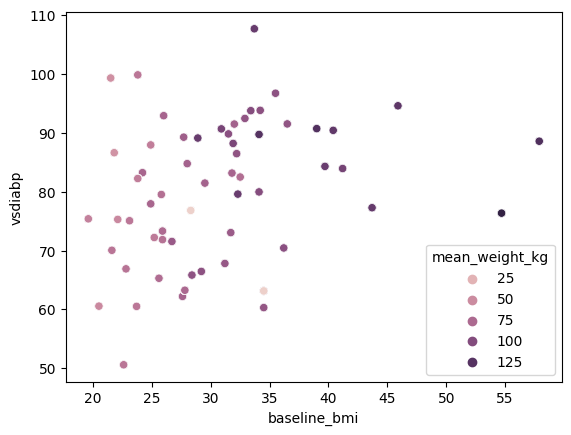

In [323]:
sns.scatterplot(data=df_cleaned, x='baseline_bmi', y='vsdiabp', hue='mean_weight_kg')

<Axes: xlabel='baseline_bmi', ylabel='vsdiabp'>

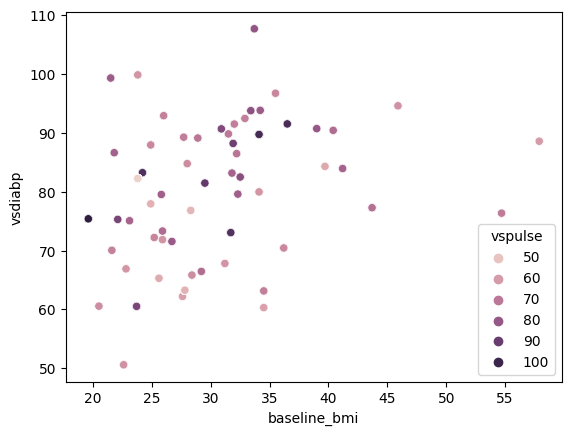

In [324]:
# Looking at pulse doesn't provide any clearer of a picture. I find that a bit odd.
sns.scatterplot(data=df_cleaned, x='baseline_bmi', y='vsdiabp', hue = 'vspulse')

# MODELING

## Approach one:
Logistic regression, chosen because we're predicting a 1 or 0 situation: either the ejection fraction is of interest, ie sub 50, or it isn't

In [325]:
#Logistic regression

# Select data for modeling
features = [
    'sex', 'race_ethnicity', 'baseline_bmi',
    'vsdiabp', 'vspulse', 'oxsat',
    'num_st_change_events'
]

# Convert relevant features into floats
cols_to_convert = ['baseline_bmi','vsdiabp', 'vspulse', 'oxsat','num_st_change_events']
df_cleaned[cols_to_convert] = df_cleaned[cols_to_convert].astype(float)

response_variable = ['is_of_interest']
df_model = df_cleaned[features + response_variable]

# Encode sex and race correctly
df_encoded = pd.get_dummies(df_model, columns=['sex', 'race_ethnicity'], drop_first=True)
df_encoded = df_encoded.dropna()

# Separate target and predictors
X_cols = df_encoded.columns.tolist()
X_cols.remove('is_of_interest')
X = df_encoded[X_cols]
y = df_encoded[response_variable]

# Scale numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# Instantiate + fit model
model = LogisticRegression()
model.fit(X_train, y_train.values.ravel())

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# ROC AUC
print("AUC score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

       False       0.96      0.93      0.94       183
        True       0.19      0.30      0.23        10

    accuracy                           0.90       193
   macro avg       0.57      0.61      0.59       193
weighted avg       0.92      0.90      0.91       193

[[170  13]
 [  7   3]]
AUC score: 0.8404371584699454


The precision and recall results tell us that the logistic regression's preformance is pretty poor when it comes to guessing the event of interest. Our confusion matrix indicates that very few of the outcomes of interest were correctly predicted.

The AUC score, however, tells us that at least the model effectively separates the two ejection outcomes across classification thresholds.

## Approach two: 

Random forest. Bearing in mind the difficulties encountered (high AUC, low precision/recall) with logistic regression, my second attempt will be a random forest because it's strong at a few things I think are true about our data:
1. Capturing non-linear relationships
2. Handling mixed data types
3. Resilient versus outliers

In [326]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Instantiate + fit model
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced') #balanced to handle class imbalance
model_rf.fit(X_train, y_train.values.ravel())

# Predict
y_pred = model_rf.predict(X_test)
y_proba = model_rf.predict_proba(X_test)[:, 1]

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# ROC AUC
print("AUC score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

       False       0.98      1.00      0.99       279
        True       1.00      0.83      0.91        30

    accuracy                           0.98       309
   macro avg       0.99      0.92      0.95       309
weighted avg       0.98      0.98      0.98       309

[[279   0]
 [  5  25]]
AUC score: 1.0


The random forest model performs well enough to spark suspicion...Even at extremely large (40%!) test set sizes, it has exceptionally high precision, recall, and AUC. This most likely speaks to a very high correlation between the features and ejection fraction. In most situations this obviously isn't ideal, and speaks to the necessity of a different feature set if our goal is to meaningfully predict an outcome with less-than-obvious features. Further consultation with a healthcare professional well-versed in the meaning of the underlying features would help us determine whether that's the case. Alternately, it's possible that there are several extremely potent indicators of a sub-50% ejection fraction which are must-watch health outcomes for any patient of interest, and this model approach proves their importance as topics of monitoring and study.